## Setup

In [4]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [6]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [7]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [8]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [1]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "block group", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",     # population
                        total_units = "B25001_001",  # housing units
                        med_inc="B19013_001"         # median income
                      ), 
                      year = 2021,
                      survey="acs5",  
                      geometry=T)

nyc_census_data


UsageError: Cell magic `%%R` not found.


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [21]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

nyc_census_data

Simple feature collection with 6807 features and 8 fields (with 49 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 6,807 × 9
   GEOID    NAME                   geometry population_estimate med_inc_estimate
   <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608109… Bloc… (((-73.844 40.57951, -73…                1183            82000
 2 3606101… Bloc… (((-74.00162 40.77455, -…                   0               NA
 3 3600505… Bloc… (((-73.79188 40.85522, -…                 887           118514
 4 3606101… Bloc… (((-73.95881 40.78086, -…                 984           205455
 5 3604703… Bloc… (((-73.94244 40.66673, -…                 612            85313
 6 3606100… Bloc… (((-74.00553 40.74582, -…                1508               NA
 7 3608100… Bloc… (((-73.86806 40.69118, -…                1932            78500
 8 3608501… Bloc… (((

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [28]:
%%R 

# Extract borough name from NAME by splitting strings like 
# "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(3) %>% str_trim()
    )

nyc_census_data

Simple feature collection with 6807 features and 9 fields (with 49 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 6,807 × 10
   GEOID    NAME                   geometry population_estimate med_inc_estimate
 * <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608109… Bloc… (((-73.844 40.57951, -73…                1183            82000
 2 3606101… Bloc… (((-74.00162 40.77455, -…                   0               NA
 3 3600505… Bloc… (((-73.79188 40.85522, -…                 887           118514
 4 3606101… Bloc… (((-73.95881 40.78086, -…                 984           205455
 5 3604703… Bloc… (((-73.94244 40.66673, -…                 612            85313
 6 3606100… Bloc… (((-74.00553 40.74582, -…                1508               NA
 7 3608100… Bloc… (((-73.86806 40.69118, -…                1932            78500
 8 3608501… Bloc… ((

### Step 5 | Example Plots

Let's practice with histograms

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 1185 rows containing non-finite outside the scale range (`stat_bin()`). 



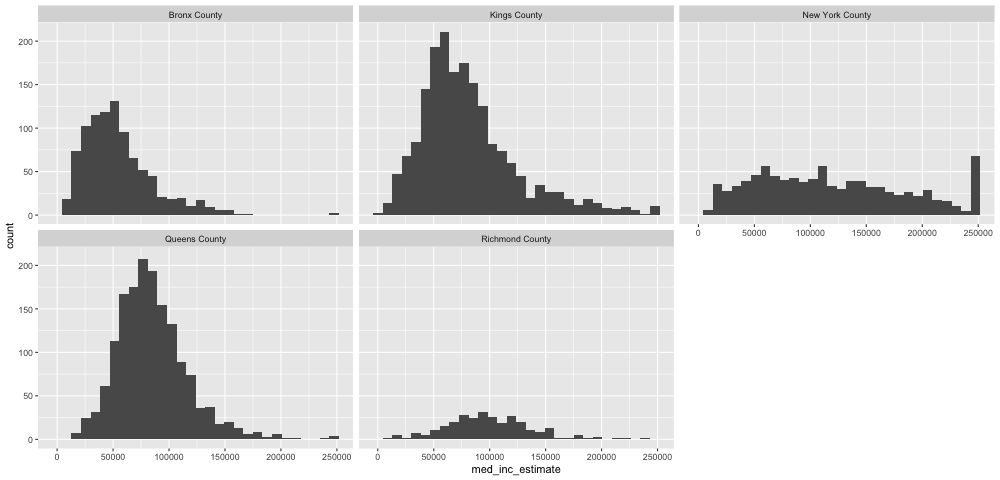

In [26]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=med_inc_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1185 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 1185 rows containing missing values or values outside the scale range
(`geom_point()`). 



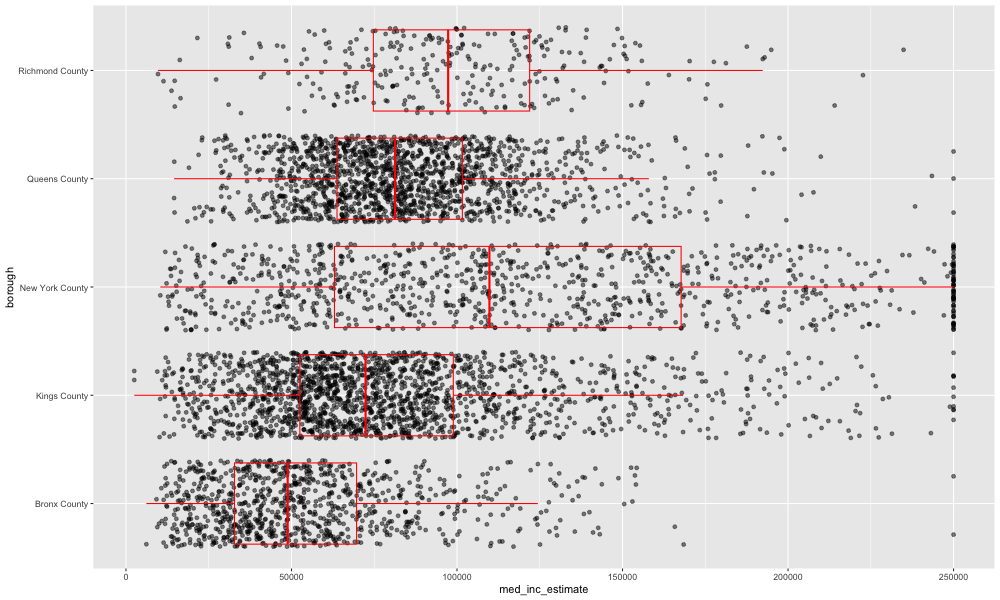

In [27]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=med_inc_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In [29]:
%%R 

library(tigris)

# remove water from the shapefiles
# https://walker-data.com/tidycensus/articles/spatial-data.html
nyc_census_data <- nyc_census_data %>% 
    erase_water()

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 7 rows containing missing values or values outside the scale range
(`geom_sf()`). 



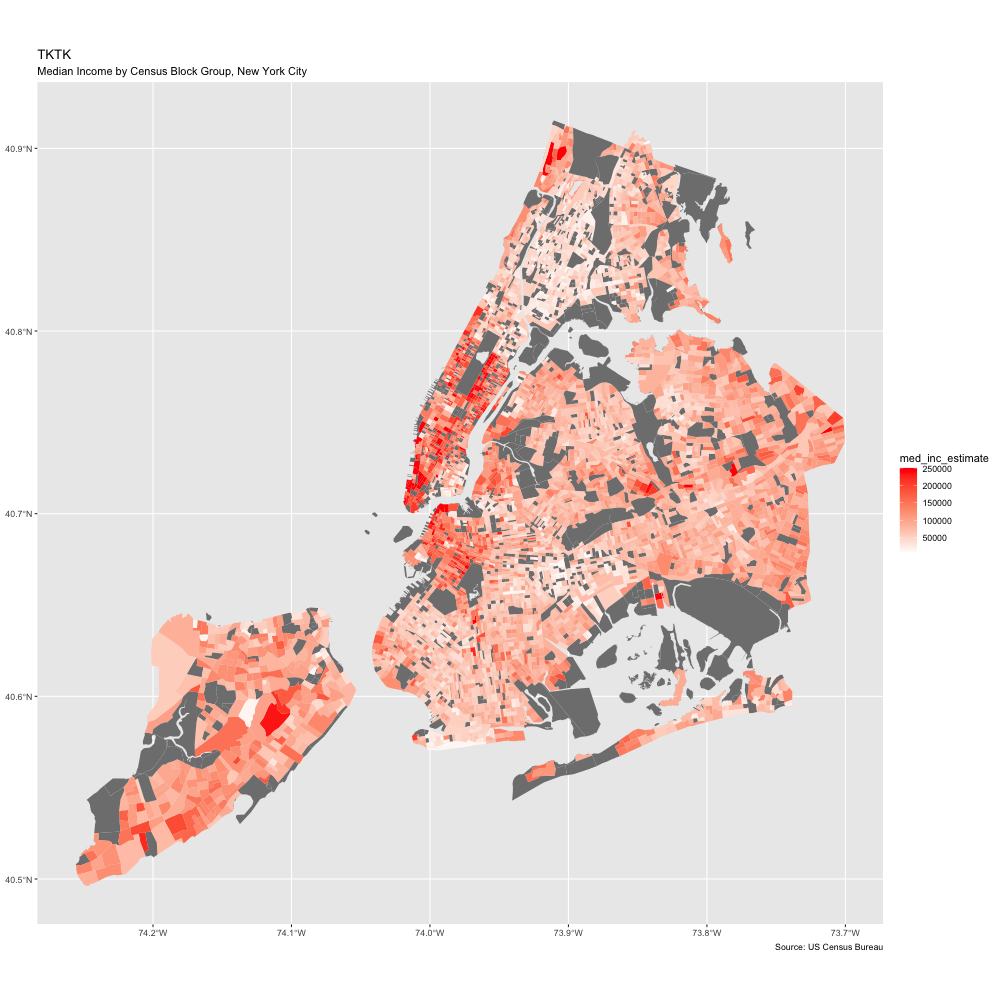

In [31]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = med_inc_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "Median Income by Census Block Group, New York City",
    caption = "Source: US Census Bureau"
  )


## Step 7 | Your Turn - Pick a different geography

- 👉 Here are the various [geographies you can use with tidycensus](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus). Try changing the analysis from the census tract level to the something more granular like `block group`. What do you notice that you didn't when looking at the tract-level data?

    **hint**: If you select block group, you may have to modify the code in **step 5** 
    > 
    > When you ask for **census tracts**, the NAME variable looks like this `Census Tract 147, Queens County, New York`
    >
    > The code in step 5 is currently set up to split on commas and take the second item (in this case `Queens County`).
    >
    > ```r
    >   nyc_census_data <- nyc_census_data %>% 
    >        mutate(
    >        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
    >    ) 
    >
    >    nyc_census_data
    >```
    >
    >But when you ask for data by **block group**, the `NAME` variable looks like this `Block Group 0, Census Tract 135.02, New York County, New York`. 
    >
    >So you will have to modify the code to extract the borough from the **block group** rather than the **census tract** name.
    

## Step 8 | Your Turn - Explore: Pick a your own variable or variables and geography level


- 👉 Pick a different variable other than median income and re-run the notebook. Use [https://censusreporter.org/](https://censusreporter.org) figure out what variable or variables you'd like to explore and add them to the list in **step 2**. 

    
    *hint*: Remember, you can create new columns in **step 5** using `mutate`. For example, the following code would both split the census tract out of the NAME column, and also 

    ```r
    nyc_census_data <- nyc_census_data %>% 
        mutate(
            borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
            units_per_person = total_unitstotal_units_estimate / population_estimate
        ) 

    nyc_census_data
    ```



-  👉 Describe the output, what questions does this raise for you?

In [13]:
# The blocks are smaller and more accurate than tract level, but is smaller granularity always better?

-  👉 Do your conclusions or questions change if you pick a different geography?

In [14]:
# answer here